In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.linear_model import LinearRegression

In [3]:
x0 = np.random.normal(0,1,100000)
x1 = np.random.normal(0,1,100000)

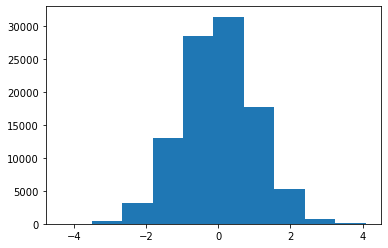

In [28]:
plt.hist(x0);

In [5]:
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow as tf

In [30]:
zero = [0]*100000

In [45]:
X = np.concatenate((np.c_[x0, zero], np.c_[zero, x1]))
np.random.shuffle(X)
print(X)

[[-0.44694793  0.        ]
 [ 0.         -0.96008461]
 [-0.84044752  0.        ]
 ...
 [ 0.02479429  0.        ]
 [-0.79452475  0.        ]
 [ 1.5721071   0.        ]]


In [46]:
def myloss2d(y_true, y_pred, alpha = 0.01):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - alpha*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - alpha*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput

In [47]:
#setup the model

myinput_2d = Input(shape=(2,))
encoded_2d = Dense(5, activation='elu')(myinput_2d)
encoded_2d = Dense(5, activation='elu')(encoded_2d)
encoded_2d = Dense(2, activation='linear')(encoded_2d)

encoder_2d = Model(myinput_2d, encoded_2d)
encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
autoencoder_2d = Model(myinput_2d, encoder2_2d)

combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

myinput_classify_2d = Input(shape=(2,))
myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

preds = []
preds += [encoder_2d.predict(X)]

num_iters = 20

for i in range(num_iters):
    print("on i=",i)
    #Now, train the classifier
    encoded_x_2d = encoder_2d.predict(X)
    myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)))
        
    #Now, update the autoencoder
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = False

    combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
    combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)))
    
    autoencoder_2d.compile(optimizer='adam', loss='mse')
    autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x)))
    
    preds += [encoder_2d.predict(X)]
    
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = True

on i= 0
100/100 [==============================] - 1s 11ms/step - loss: 0.3634
Epoch 1/5
200/200 [==============================] - 0s 2ms/step - loss: 0.1733
Epoch 2/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0478
Epoch 3/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 4/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 5/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0134
on i= 1
100/100 [==============================] - 1s 12ms/step - loss: -0.0285
Epoch 1/5
200/200 [==============================] - 0s 2ms/step - loss: 0.1871
Epoch 2/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 4/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 5/5
200/200 [==============================] - 0s 2ms/step - loss: 0.0078
on i= 2
100/100 [========================

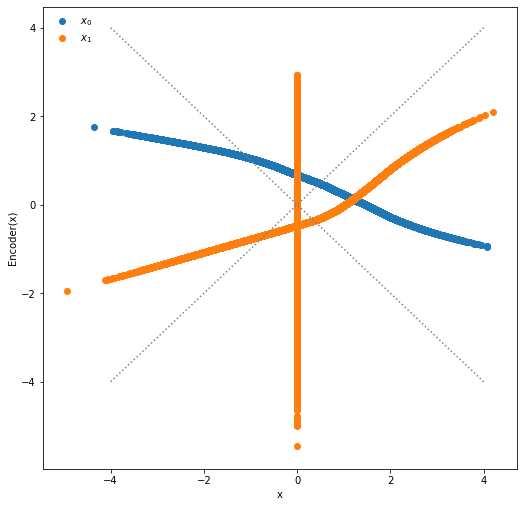

In [48]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],preds[-1][:,0],label="$x_0$")
plt.scatter(X[:,1],preds[-1][:,1],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Encoder(x)")
plt.legend(frameon=False)

In [49]:
mypreds = combinedModel_classifier_2d.predict(X)

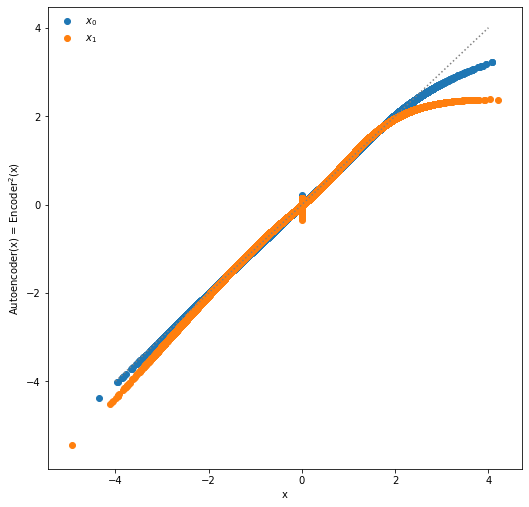

In [50]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],mypreds[:,2],label="$x_0$")
plt.scatter(X[:,1],mypreds[:,3],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
plt.legend(frameon=False)

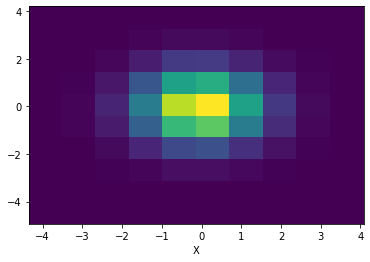

In [51]:
plt.hist2d(x0, x1);
plt.xlabel("X");

In [52]:
Y = encoder_2d.predict(X)

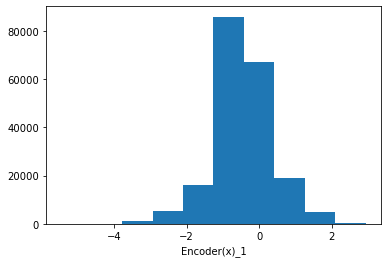

In [53]:
plt.hist(Y[:,1]);
plt.xlabel("Encoder(x)_1");